### Importing the pretrained NLP model

In this notebook we will first apply a pre trained model to process the titles from Reddit, and then we perform a simple LinearRegression. The results are not satisfying.

Importing the pre trained NLP model:

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <B3E58761-2785-34C6-A89B-F37110C88A05> /opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <3BD7C270-CE25-3DCF-A6C8-B9D7148F8ADE> /opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


Importing the dataset from the .zip file:

In [2]:
from data_preparation_utilities import read_csv_from_zip
Combined_News_DJIA, DJIA_table, RedditNews, Test_dates = read_csv_from_zip()
DJIA_table = DJIA_table.iloc[::-1].reset_index(drop=True)

In the following I search for NaN entries in the dataset

In [36]:
Combined_News_DJIA = Combined_News_DJIA.drop(columns=['Date', 'Label'], axis=1)
nan_count_per_column = Combined_News_DJIA.isna().sum()
nan_positions = Combined_News_DJIA.isna().stack()
nan_positions = nan_positions[nan_positions]

print(nan_positions)


277  Top23    True
     Top24    True
     Top25    True
348  Top24    True
     Top25    True
681  Top24    True
     Top25    True
dtype: bool


Removing the NAN entries in the dataset

In [48]:
Combined_News_DJIA.iloc[277, -3:] = Combined_News_DJIA.iloc[277, -6:-3]

Combined_News_DJIA.iloc[348, -2:] = Combined_News_DJIA.iloc[277, -4:-2]

Combined_News_DJIA.iloc[681, -2:] = Combined_News_DJIA.iloc[681, -4:-2]

In [ ]:
import scipy
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
Combined_News_DJIA_np = Combined_News_DJIA.to_numpy()
n = Combined_News_DJIA_np.shape[0]
final = np.zeros((1, 75))
for i in range(n):
    print(i)
    x = [char for char in Combined_News_DJIA_np[i].tolist()]
    input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
    logits = model_finbert(**input_sequence).logits
    probabilities = F.softmax(logits, dim=-1).view(1, 75)
    probabilities_np = probabilities.detach().numpy()
    final = np.concatenate((final, probabilities_np), axis=0)

df = pd.DataFrame(final)

# Save the DataFrame as a CSV file
df.to_csv('tensor_data.csv', index=False)


In [5]:
import pandas as pd

df = pd.read_csv('titles_after_NLP.csv')
df = df.drop(index=0)
df = df.reset_index(drop=True)

### Prepared the input

In [7]:
adj_close = Combined_News_DJIA['Label']
merged_df = pd.concat([df, adj_close], axis=1)
input = merged_df.iloc[:1863, :]

### Prepared the output

In [9]:
output = DJIA_table['Close']

### Now we start to train the model

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [11]:
# Split the data into training and testing sets
x = input  # Independent variable
y = output     # Dependent variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
# Create and train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [128]:

# Make predictions on the test set
y_pred = model.predict(x_test)

In [129]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 6587046.302039085
R^2 Score: 0.308084146089734


(373,)


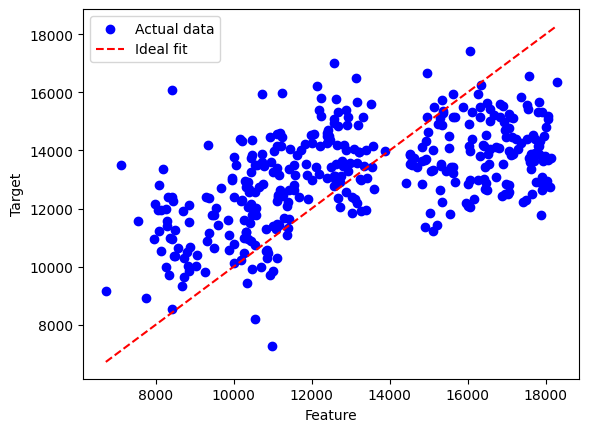

In [150]:
# Plot the results

domain = np.arange(1, len(y_test) + 1)
print(domain.shape)


plt.scatter(y_test, y_pred, color='blue', label='Actual data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()